## Import libraries and read data

In [129]:
path = "sparkify_data.json"

In [130]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
from pyspark.sql import SparkSession
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround
from pyspark.sql.types import IntegerType, DateType, TimestampType
from pyspark.sql.types import IntegerType, DateType, TimestampType
from pyspark import SparkContext, SparkConf
from pyspark.sql import Window
from pyspark.sql.functions import udf, col, concat, count, lit, avg, lag, first, last, when

from time import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import pandas as pd

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, LinearSVC
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, Evaluator

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [131]:
# Create spark session
spark = SparkSession.builder \
.master("local") \
.appName("Analysis") \
.getOrCreate()

In [132]:
# read data file
df = spark.read.json(path)

#count of instances and attributes
print("Number of instances - %g " %df.count())
print("Number of attributes - %g " %len(df.take(1)[0]))

Number of instances - 286500 
Number of attributes - 18 


In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## Data Preprocessing

In [6]:
# remove duplicates from userID
unique_users = df.select("userId").dropDuplicates()
print("Number of unique users - %g " %unique_users.count())

# remove duplicates from sessionId
unique_sessions = df.select('sessionId').dropDuplicates()
print("Number of sessions - %g " %unique_sessions.count())

#remove missing values
users = df.dropna(how = "any", subset = ["userId", "sessionId"])
#remove invalid userID
users = users.filter(users["userId"] != "")
print("Number of valid instances - %g " %users.count())

Number of unique users - 226 
Number of sessions - 2354 
Number of valid instances - 278154 


#### Missing values

<Figure size 1296x432 with 0 Axes>

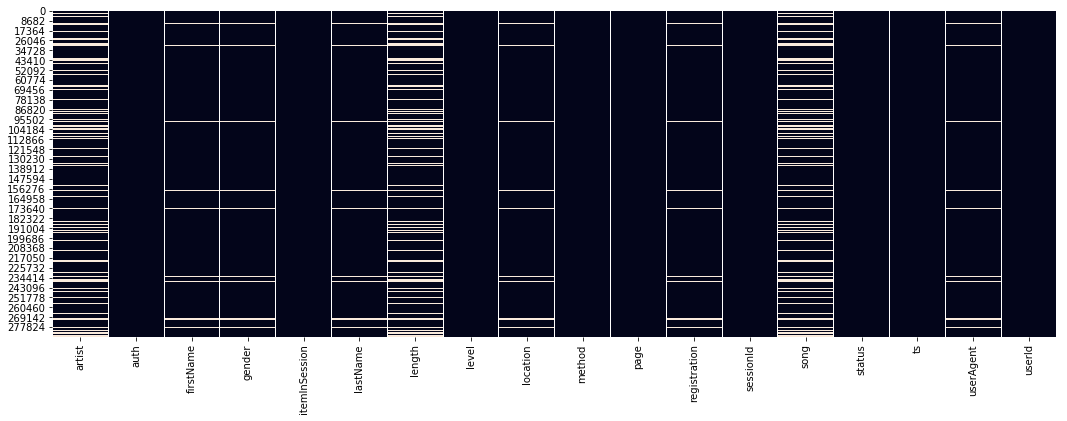

In [7]:
plt.figure(figsize=(18,6))
sns.heatmap(df.toPandas().isnull(),cbar=False)

In [8]:
registered = df.dropna(how = "any", subset = ["registration"])
non_registered_users = df.count() - registered.count()
print("number of non registered users %g" %non_registered_users)

number of non registered users 8346


In [9]:
df_pd = df.toPandas()
page_info_with_missing_song_info = df_pd[df_pd.artist.isnull()]['page'].value_counts()
print(page_info_with_missing_song_info)

Home                         14457
Thumbs Up                    12551
Add to Playlist               6526
Add Friend                    4277
Roll Advert                   3933
Login                         3241
Logout                        3226
Thumbs Down                   2546
Downgrade                     2055
Help                          1726
Settings                      1514
About                          924
Upgrade                        499
Save Settings                  310
Error                          258
Submit Upgrade                 159
Submit Downgrade                63
Cancellation Confirmation       52
Cancel                          52
Register                        18
Submit Registration              5
Name: page, dtype: int64


In [10]:
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df = df.filter(df["userId"] != "")

In [11]:
# df.count()
# Data=pd.read_csv("sparkify_data.json")
# Data.describe()

In [12]:
df.select(['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName',
           'length', 'level', 'location', 'method', 'page']).show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|
|    Adam Lambert|Logged In|    Colin|     M|           51| Freeman| 282.8273| paid|     Bakersfield, CA|   PUT|NextSong|
|          Enigma|Logged In|    Micah|     M|           80|    Long|262.71302| free|Boston-Cambridge-...|   PUT|NextSong|
|       Daft Punk|Logged In|    Colin|     M|           52| Freeman|223.60771| paid|     Bakersfield, CA|   PUT|NextSong|
+----------------+------

In [13]:
# sample user data
df.where(df.userId == 25).select(['userId','sessionId','itemInSession','auth','level','page','ts']).show(20)

+------+---------+-------------+---------+-----+----------+-------------+
|userId|sessionId|itemInSession|     auth|level|      page|           ts|
+------+---------+-------------+---------+-----+----------+-------------+
|    25|      222|            0|Logged In| paid|  NextSong|1538369228000|
|    25|      222|            1|Logged In| paid|  NextSong|1538369407000|
|    25|      222|            2|Logged In| paid|  NextSong|1538369571000|
|    25|      222|            3|Logged In| paid|      Home|1538369625000|
|    25|      222|            4|Logged In| paid|  NextSong|1538369836000|
|    25|      222|            5|Logged In| paid|  NextSong|1538370013000|
|    25|      222|            6|Logged In| paid|Add Friend|1538370014000|
|    25|      222|            7|Logged In| paid|  NextSong|1538370161000|
|    25|      222|            8|Logged In| paid|  NextSong|1538370400000|
|    25|      222|            9|Logged In| paid|  NextSong|1538370679000|
|    25|      222|           10|Logged

#### Timestamp data

In [14]:
#Max and Min timestamps
min_ts = df.select('ts').groupby().min('ts').collect()
max_ts = df.select('ts').groupby().max('ts').collect()

min_time = datetime.datetime.fromtimestamp(min_ts[0][0]/1000.0).strftime("%Y-%m-%d %H:%M:%S")
max_time = datetime.datetime.fromtimestamp(max_ts[0][0]/1000.0).strftime("%Y-%m-%d %H:%M:%S")

print("Start time %s" %min_time)
print("End time %s" %max_time)

Start time 2018-10-01 02:01:57
End time 2018-12-03 02:11:16


In [15]:
# create readable timestamp
df = df.withColumn('tsDate', (df['ts'] / 1000).cast(TimestampType()))

In [16]:
df.select('userId', 'page', 'tsDate').sort('ts').show(10)

+------+---------------+-------------------+
|userId|           page|             tsDate|
+------+---------------+-------------------+
|    30|       NextSong|2018-10-01 02:01:57|
|     9|       NextSong|2018-10-01 02:03:00|
|    30|       NextSong|2018-10-01 02:06:34|
|     9|       NextSong|2018-10-01 02:06:56|
|    30|       NextSong|2018-10-01 02:11:16|
|     9|       NextSong|2018-10-01 02:11:18|
|     9|       NextSong|2018-10-01 02:14:46|
|    30|       NextSong|2018-10-01 02:14:59|
|    30|Add to Playlist|2018-10-01 02:15:05|
|    30|       NextSong|2018-10-01 02:18:04|
+------+---------------+-------------------+
only showing top 10 rows



## Data Analysis

In [17]:

unique_user_gender =  df.select(['userId','gender']).dropDuplicates().dropna().groupby('gender').count().toPandas() 
tot_unique_sex = (unique_user_gender.set_index('gender') / sum(unique_user_gender['count']))
print("gender based on App users")
print(unique_user_gender)

sex = df.select(['userId','gender']).dropna().groupby('gender').count().toPandas()
tot_sex = (sex.set_index('gender') / sum(sex['count']))
sex_activity = df.groupby('gender').count().toPandas()
tot_sex_activity = (sex_activity.set_index('gender') / sum(sex_activity['count']))

print("Gender based on activity")
print(sex)

gender based on App users
  gender  count
0      F    104
1      M    121
Gender based on activity
  gender   count
0      F  154578
1      M  123576


Text(0, 0.5, 'Share')

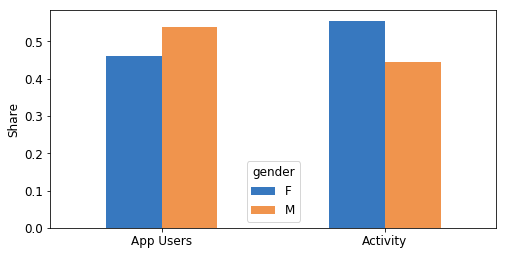

In [18]:
diff = tot_unique_sex.merge(tot_sex_activity, on='gender')
diff.columns = ['App Users', 'Activity']

plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams.update({'font.size': 12})
colors = ["windows blue", "faded orange"]
palette = sns.xkcd_palette(colors)
color1 = palette[0]
color2 = palette[1]
diff.transpose().plot.bar(rot = 0, color = [color1, color2]);
plt.ylabel('Share');
plt.savefig('gender')

there is more male users using the application but higher share of logs are from the female users.

In [19]:
level_data =  df.select(['userId','level']).dropDuplicates().dropna().groupby('level').count().toPandas() 
tot_level = (level_data.set_index('level') / sum(level_data['count']))
print(level_data)

tier_analysis = df.groupby(['userId'])\
.agg(Fsum(when(col('level') == 'free', 1).otherwise(0)).alias('freeTier'),
     Fsum(when(col('level')=='paid', 1).otherwise(0)).alias('paidTier'))

tier_analysis = tier_analysis.withColumn('share', col('freeTier') / (col('freeTier') + col('paidTier')))
tier_analysis_pd = tier_analysis.toPandas()



  level  count
0  free    195
1  paid    165


Text(0, 0.5, 'User Count')

Text(0.5, 0, 'Logs in the free plan / all logs')

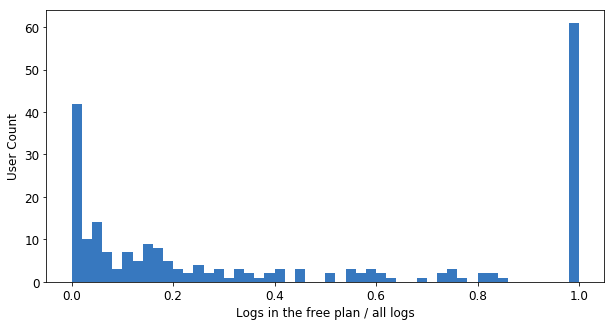

In [20]:
plt.rcParams['figure.figsize'] = (10,5)
tier_analysis_pd['share'].plot.hist(bins = 50,  color = color1);
plt.ylabel('User Count');
plt.xlabel('Logs in the free plan / all logs');
plt.savefig('Subscription Change')

From the histogram above we can see that the majority of users seems to stick to their subscription plan, as more than 40 users (out of 225) interacted with the service mostly using the premium service, and around 60 stayed in the free tier throughout the entire observation period.

In [21]:
df.groupby('page').count().sort('count', ascending = False).show(20)

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



Text(0.5, 0, '')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Interaction type distribution using log scale')

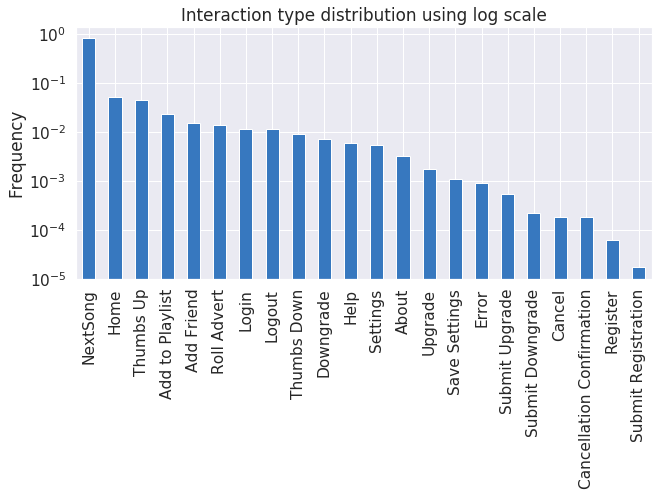

In [144]:
page_pd = df.groupby('page').count().sort('count', ascending = False).toPandas()
page_pd['Subset'] = page_pd['count'] / sum(page_pd['count'])
# diff_pd = page_pd_full.merge(page_pd, on = 'page')

plt.rcParams['figure.figsize'] = (10,7)
# page_pd.plot(x='page', y= 'Subset', kind = "bar",  color = [color1]);
page_pd.plot(x='page', y= 'Subset', kind = "bar",  color = [color1], logy = True);
plt.xlabel("");
plt.ylabel("Frequency");
plt.title("Interaction type distribution using log scale");
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.45);
plt.savefig('interactiontype1');
plt.legend().remove()

We are not able to investigate the actual distribution of the other pages because of the dominance of the NextSong page.

In [23]:
nextPage_count = page_pd[page_pd['page']=='NextSong']
print(nextPage_count)

       page   count    Subset
0  NextSong  228108  0.820078


Text(0.5, 0, '')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Interaction type distribution (ex NextSong)')

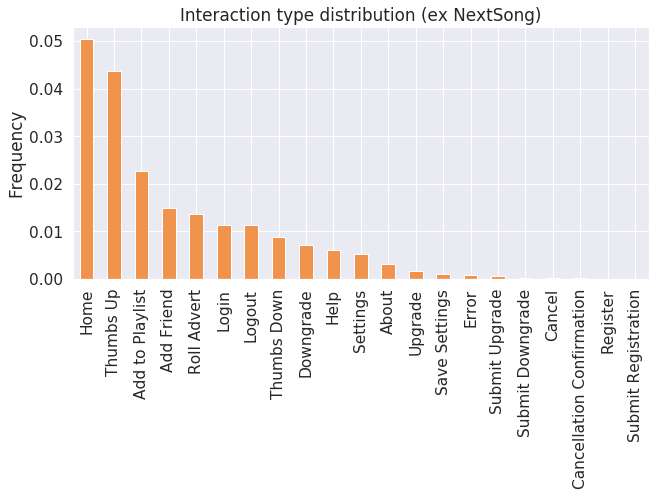

In [139]:
page_pd[page_pd['page']!='NextSong'].plot(x='page', y= 'Subset', kind = "bar", color = [color2]);

plt.rcParams['figure.figsize'] = (10,7)
plt.xlabel("");
plt.ylabel("Frequency");
plt.title("Interaction type distribution (ex NextSong)");
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.45);
plt.savefig('interactiontype2')
plt.legend().remove()

In [25]:
# investigate the target feature (page)
df.filter("page = 'Cancellation Confirmation'").show(20)

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|             tsDate|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+
|  null|Cancelled|   Adriel|     M|          104|  Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|2018-10-07 22:26:30|
|  null|Cancelled|    Diego|     M|           56|    Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...

Cancellation Confirmation page count in the data for both paid and free users (Churn count)

In [26]:
churn_count=df.select(['userId','page']).filter("page=='Cancellation Confirmation'").dropDuplicates().count()
print(churn_count)

52


Percentage of users churn

In [27]:
user_churn_rate=churn_count/unique_users.count()*100
print(user_churn_rate)

23.008849557522122


#### Create the Target feature

In [28]:
## Create the target feature (label)
create_label = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

df = df.withColumn("Churn", create_label("page"))


#### Churn of users - Based on Gender

[Text(0, 0.5, 'User Count'), Text(0.5, 0, 'Gender')]

  gender  churn  count
0      M      1     32
1      F      0    104
2      F      1     20
3      M      0    121


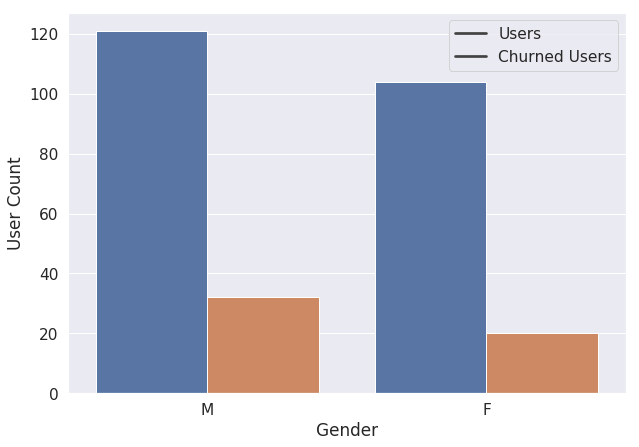

In [78]:
gender_churn=df.select("userId","gender",col("Churn").alias("churn")).dropDuplicates().groupby(['gender','churn']).count().toPandas()
bar = sns.barplot(x='gender',y='count' ,hue='churn', data=gender_churn, dodge=True)
bar.set(xlabel='Gender', ylabel='User Count')
bar.legend(['Users','Churned Users'])
print(gender_churn)

#### Churn of users - Based on Level (Free or paid)

[Text(0, 0.5, 'User Count'), Text(0.5, 0, 'Level(Free/Paid User)')]

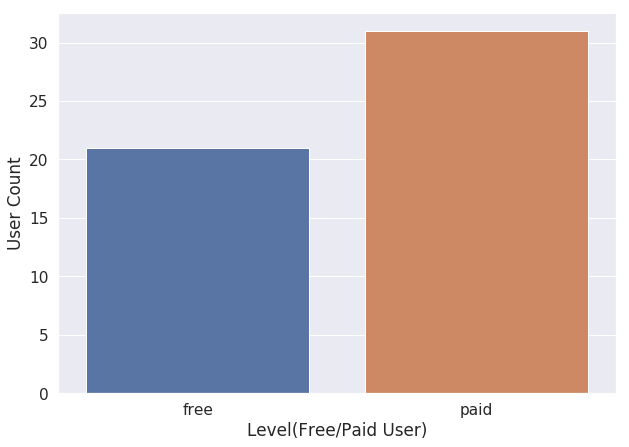

In [79]:
churn_level = df.filter("page=='Cancellation Confirmation'").select(['level',col('Churn') \
                .alias('churn')]).groupby('level').count().toPandas()

bar_level = sns.barplot(x='level',y='count',data=churn_level)
bar_level.set(xlabel='Level(Free/Paid User)', ylabel='User Count')

## Feature Engineering and devide dataset

Aggregate data by userID with level, page and gender

In [85]:
windowuser = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)


# identify users who cancelled service by getting last page he is on
df = df.withColumn("endstate", last(col('page')).over(windowuser))


In [86]:
df_user = df.groupby('userId')\
.agg(
     first(when(col('level') == 'paid', 1).otherwise(0)).alias('level'),
     first(when(col('gender') == "F", 1).otherwise(0)).alias('gender'),
     first(col('endstate')).alias('page')
)


In [87]:
df_user.printSchema

<bound method DataFrame.printSchema of DataFrame[userId: string, level: int, gender: int, page: string]>

In [34]:
# rows in a aggregated dataset
df_user.select(['userId','gender','level', 'page']).show(5)

+------+------+-----+--------------------+
|userId|gender|level|                page|
+------+------+-----+--------------------+
|100010|     1|    0|              Logout|
|200002|     0|    0|           Thumbs Up|
|   125|     0|    0|Cancellation Conf...|
|   124|     1|    1|                Home|
|    51|     0|    1|Cancellation Conf...|
+------+------+-----+--------------------+
only showing top 5 rows



In [88]:
# Create target feature on aggrigated dataset
df_user = df_user.withColumn('Churn', when(df_user.page == "Cancellation Confirmation", "Cancellation Confirmation" ).otherwise("na"))

df_user.show(10)

+------+-----+------+--------------------+--------------------+
|userId|level|gender|                page|               Churn|
+------+-----+------+--------------------+--------------------+
|100010|    0|     1|              Logout|                  na|
|200002|    0|     0|           Thumbs Up|                  na|
|   125|    0|     0|Cancellation Conf...|Cancellation Conf...|
|   124|    1|     1|                Home|                  na|
|    51|    1|     0|Cancellation Conf...|Cancellation Conf...|
|     7|    0|     0|           Thumbs Up|                  na|
|    15|    1|     0|            NextSong|                  na|
|    54|    1|     1|Cancellation Conf...|Cancellation Conf...|
|   155|    0|     1|                Home|                  na|
|100014|    1|     0|Cancellation Conf...|Cancellation Conf...|
+------+-----+------+--------------------+--------------------+
only showing top 10 rows



add features and convert to vector form

In [89]:

indexer = StringIndexer(inputCol="Churn", outputCol="label")

# Adding the two binary features
binary_columns = ['level', 'gender']
total_assembler = VectorAssembler(inputCols = binary_columns , outputCol = "features")

Split data into 3 sets. Train, validation and test

In [91]:
# devide data into train & test
train, test_val = df_user.randomSplit([0.6, 0.4], seed=42)
validation, test = test_val.randomSplit([0.5, 0.5], seed=123)


## Modeling

### Logistic Regression Model

In [118]:
#initiate logistic regression classification model

lr =  LogisticRegression(maxIter=10, elasticNetParam=0.1)
pipeline_lr = Pipeline(stages = [total_assembler,indexer, lr])


In [119]:
param = ParamGridBuilder().addGrid(lr.regParam,[0.0,0.1]).build()

crossval = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=param,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [120]:
start_time_lr =time()

# train model
model = crossval.fit(train)
end_time_lr = time()

Time to train logistic regression model 

In [121]:
print(end_time_lr-start_time_lr)

236.4459149837494


In [122]:
train_output_df = model.transform(train)
validation_output_df = model.transform(validation)
test_output_df = model.transform(test)

In [123]:
train_predictionAndLabels = train_output_df.select("prediction", "label")
validation_predictionAndLabels = validation_output_df.select("prediction", "label")
test_predictionAndLabels = test_output_df.select("prediction", "label")

In [124]:
# evaluation metrics types
metrics = ['weightedPrecision', 'weightedRecall', 'accuracy', 'f1']

In [125]:
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(metricName=metric)
    print('Train ' + metric + ' = ' + str(evaluator.evaluate(train_predictionAndLabels)))
    print('Validation ' + metric + ' = ' + str(evaluator.evaluate(validation_predictionAndLabels)))
    print('Test ' + metric + ' = ' + str(evaluator.evaluate(test_predictionAndLabels)))


Train weightedPrecision = 0.6244315125434007
Validation weightedPrecision = 0.6327479338842975
Test weightedPrecision = 0.4444444444444444
Train weightedRecall = 0.7902097902097902
Validation weightedRecall = 0.7954545454545454
Test weightedRecall = 0.6666666666666666
Train accuracy = 0.7902097902097902
Validation accuracy = 0.7954545454545454
Test accuracy = 0.6666666666666666
Train f1 = 0.6976070804195804
Validation f1 = 0.7048331415420023
Test f1 = 0.5333333333333333


In [126]:
#print correct predictions
print(test_output_df.filter(test_output_df.label == test_output_df.prediction).count())
print(test_output_df.count())

26
39


In [127]:
pr = BinaryClassificationEvaluator(metricName='areaUnderPR')
roc = BinaryClassificationEvaluator(metricName='areaUnderROC')

def custom_evaluation(pred, model_name):

    pr = BinaryClassificationEvaluator(metricName='areaUnderPR')
    pr_auc=pr.evaluate(pred)
    print(f"{model_name} -> PR AUC: {pr_auc}")
    predictionRDD = pred.select(['label', 'prediction']).rdd\
                        .map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)
    conf_matrix = metrics.confusionMatrix().toArray()
    sns.set(font_scale=1.4)
    ax = sns.heatmap(conf_matrix, annot=True,annot_kws={"size": 16})
    ax.set(xlabel='Predicted Label', ylabel='True Label', title='Confusion Mtx')
    plt.show()

logistic regression -> PR AUC: 0.3767260883133094


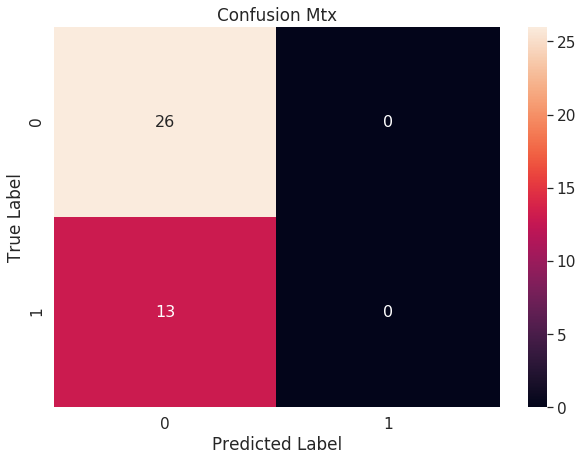

In [128]:
custom_evaluation(test_output_df, 'logistic regression')

### Decision Tree Classifier

In [103]:
dt = DecisionTreeClassifier()
pipeline_dt = Pipeline(stages=[total_assembler,indexer, dt])


param_dt = ParamGridBuilder() \
    .addGrid(dt.impurity,['entropy']) \
    .addGrid(dt.maxDepth,[3,5,7,9]) \
    .build()


cv_dt = CrossValidator(estimator=pipeline_dt,
                          estimatorParamMaps=param_dt,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)


start_time_dt = time()
# train the model
dt_model = cv_dt.fit(train)
end_time_dt = time()


Time to train decision tree classifier model

In [104]:
print(end_time_dt-start_time_dt)

273.00305104255676


In [105]:
train_output_dt = dt_model.transform(train)
validation_output_dt = dt_model.transform(validation)
test_output_dt = dt_model.transform(test)

In [106]:
train_predictionAndLabels_dt = train_output_dt.select("prediction", "label")
validation_predictionAndLabels_dt = validation_output_dt.select("prediction","label")
test_predictionAndLabels_dt = test_output_dt.select("prediction", "label")

In [107]:
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(metricName=metric)
    print('Train ' + metric + ' = ' + str(evaluator.evaluate(train_predictionAndLabels_dt)))
    print('Validation ' + metric + ' = ' + str(evaluator.evaluate(validation_predictionAndLabels_dt)))
    print('Test ' + metric + ' = ' + str(evaluator.evaluate(test_predictionAndLabels_dt)))

Train weightedPrecision = 0.6244315125434007
Validation weightedPrecision = 0.6327479338842975
Test weightedPrecision = 0.4444444444444444
Train weightedRecall = 0.7902097902097902
Validation weightedRecall = 0.7954545454545454
Test weightedRecall = 0.6666666666666666
Train accuracy = 0.7902097902097902
Validation accuracy = 0.7954545454545454
Test accuracy = 0.6666666666666666
Train f1 = 0.6976070804195804
Validation f1 = 0.7048331415420023
Test f1 = 0.5333333333333333


Decision Tree -> PR AUC: 0.3333333333333333


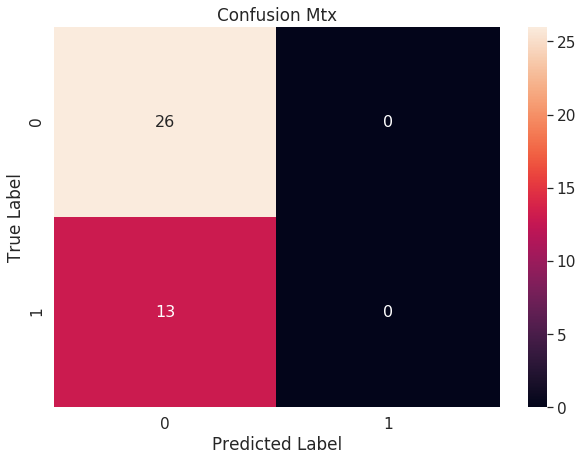

In [108]:
custom_evaluation(test_output_dt, 'Decision Tree')

### SVM

In [109]:
svm = LinearSVC()

pipeline_svm = Pipeline(stages=[total_assembler,indexer, svm])


In [110]:

param_svm = ParamGridBuilder() \
    .addGrid(svm.maxIter,[5]) \
    .addGrid(svm.regParam,[0.0,0.1]) \
    .build()

cv_svm = CrossValidator(estimator=pipeline_svm,
                          estimatorParamMaps=param_svm,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)



In [111]:
start_time_svm = time()

# train model
svm_model = cv_svm.fit(train)

end_time_svm = time()

Time to train SVM model

In [112]:
print(end_time_svm-start_time_svm)

567.4080784320831


In [113]:
train_output_svm = svm_model.transform(train)
validation_output_svm = svm_model.transform(validation)
test_output_svm = svm_model.transform(test)

In [114]:
train_predictionAndLabels_svm = train_output_svm.select("prediction", "label")
validation_predictionAndLabels_svm = validation_output_svm.select("prediction","label")
test_predictionAndLabels_svm = test_output_svm.select("prediction", "label")

In [115]:
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(metricName=metric)
    print('Train ' + metric + ' = ' + str(evaluator.evaluate(train_predictionAndLabels_svm)))
    print('Validation ' + metric + ' = ' + str(evaluator.evaluate(validation_predictionAndLabels_svm)))
    print('Test ' + metric + ' = ' + str(evaluator.evaluate(test_predictionAndLabels_svm)))

Train weightedPrecision = 0.6244315125434007
Validation weightedPrecision = 0.6327479338842975
Test weightedPrecision = 0.4444444444444444
Train weightedRecall = 0.7902097902097902
Validation weightedRecall = 0.7954545454545454
Test weightedRecall = 0.6666666666666666
Train accuracy = 0.7902097902097902
Validation accuracy = 0.7954545454545454
Test accuracy = 0.6666666666666666
Train f1 = 0.6976070804195804
Validation f1 = 0.7048331415420023
Test f1 = 0.5333333333333333


SVM -> PR AUC: 0.3767260883133094


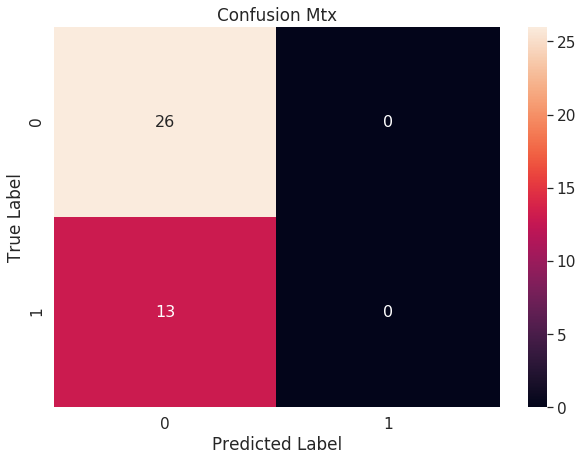

In [116]:
custom_evaluation(test_output_svm, 'SVM')